### 1. 기본 설정


- 라이브러리

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

- 불러오기 (전처리 전)

In [27]:
file_path = '../lendingClub 대출데이터셋/accepted_2007_to_2018Q4.csv'

# 필요한 컬럼만 (열= 13개)
selected_cols = [
    'loan_status',      # 타겟: 상환 여부
    'annual_inc',        # 연간 소득
    'dti',               # 총부채상환비율 (빚/소득)
    'home_ownership',    # 주거 형태 (자가, 월세 등)
    'fico_range_low',    # 신용점수 하한선
    'revol_util',        # 리볼빙 이용률
    'delinq_2yrs',       # 지난 2년간 30일 이상 연체한 횟수
    'pub_rec',           # 파산 등 공적 기록 횟수
    'loan_amnt',         # 대출 원금
    'int_rate',          # 이자율
    'term',              # 대출 기간
    'purpose',           # 대출 목적
    'grade'             # 신용 등급
]

df = pd.read_csv(file_path, usecols=selected_cols, low_memory=False)

# 행렬 개수 확인
record, columns = df.shape
print(f'행: {record}, 열: {columns}') 

행: 2260701, 열: 13


- 한글 폰트 깨짐 방지

In [28]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스
    plt.rc('font', family='NanumGothic')

# 마이너스 기호방지
plt.rcParams['axes.unicode_minus'] = False

###  2. 데이터 전처리

#### 1. 결측치 처리

- 결측치 확인

In [29]:
df.isnull().sum()

loan_amnt           33
term                33
int_rate            33
grade               33
home_ownership      33
annual_inc          37
loan_status         33
purpose             33
dti               1744
delinq_2yrs         62
fico_range_low      33
pub_rec             62
revol_util        1835
dtype: int64

- 결측치 제거 목록

1. loan_amnt, term **(제거)**
거의 모든 필수 컬럼에 공통적으로 33개의 결측치가 있는데 이는 시스템 오류나 빈줄이라고 판단하여 제거

2. delinq_2yrs, pub_rec, inq_last_6mths **(제거)**
대략 60여개의 결측치가 있음
신용 조회나 연체기록이 NaN인 경우 시스템상 해당 사항이 없다(0건) 일 확률이 높기때문에 제거

3. dti, revol_util, annual_inc **(제거)**
각각 1744, 1835개의 결측치가 있음 (annual은 33개)
해당 컬럼들은 리스크 판단의 핵심 근거로 다른 값으로 채우기엔 위험하며 비율 역시도 굉장히 적기때문에 제거

In [30]:
# 1. 
df.dropna(subset=['loan_amnt'], inplace=True)

# 2. 
drop_cols = ['delinq_2yrs', 'pub_rec']
df.dropna(subset=drop_cols, inplace=True)

# 3. 
drop_cols = ['dti', 'revol_util', 'annual_inc']
df.dropna(subset=drop_cols, inplace=True)

# 확인
print('--- 전처리 확인 ---')
df.isnull().sum()

--- 전처리 확인 ---


loan_amnt         0
term              0
int_rate          0
grade             0
home_ownership    0
annual_inc        0
loan_status       0
purpose           0
dti               0
delinq_2yrs       0
fico_range_low    0
pub_rec           0
revol_util        0
dtype: int64

#### 2. 이상치 처리

##### 1. dti(소득대비 부채비율)

- 이상치 개수 확인

In [31]:
df.loc[df['dti'] > 100].nunique()

loan_amnt          392
term                 2
int_rate           169
grade                7
home_ownership       4
annual_inc         595
loan_status          6
purpose             11
dti               2154
delinq_2yrs         13
fico_range_low      38
pub_rec              5
revol_util         882
dtype: int64

- 음수제거 AND 상한선 100으로 처리

In [32]:
df = df[df['dti'] >= 0]
df.loc[df['dti'] > 100, 'dti'] = 100
df.loc[df['dti'] > 100].nunique()

loan_amnt         0
term              0
int_rate          0
grade             0
home_ownership    0
annual_inc        0
loan_status       0
purpose           0
dti               0
delinq_2yrs       0
fico_range_low    0
pub_rec           0
revol_util        0
dtype: int64

#####  2. annual_income (연간소득)

- 연간 소득분포 산점도로 확인

- 비정상적인 값 두개 발견 (연소득 1만달러 이상, 0.6만 달러 이상)

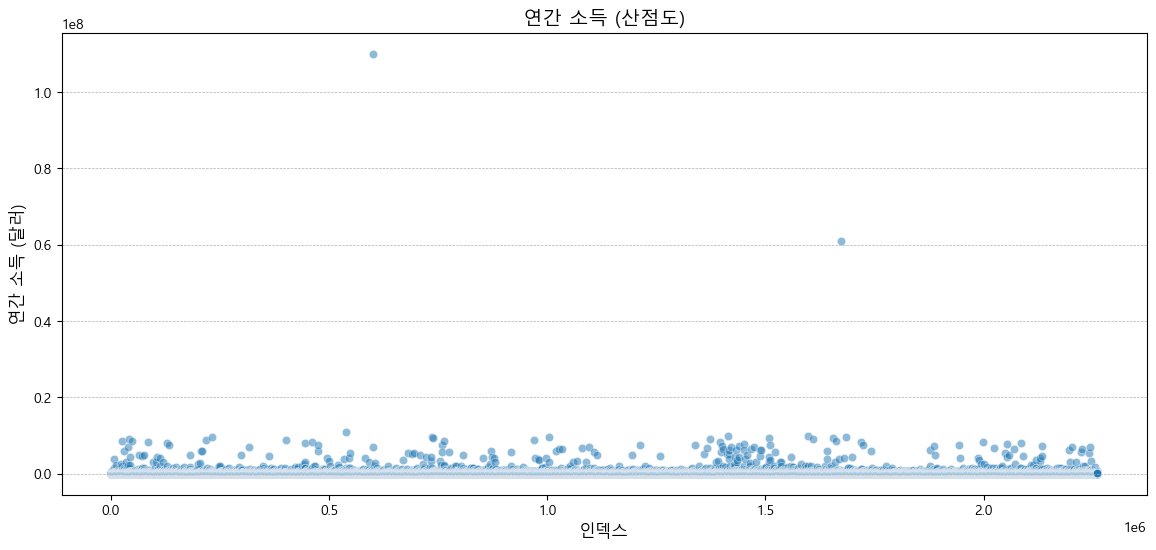

In [33]:
# 산점도로 전체 확인
plt.figure(figsize=(14,6))

sns.scatterplot(x=df.index, y=df['annual_inc'], alpha=0.5)

plt.title('연간 소득 (산점도)' ,fontsize=14)
plt.ylabel('연간 소득 (달러)', fontsize=12)
plt.xlabel('인덱스', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.show()

- annual_inc 1000만 이상 제거 

In [34]:
df = df[df['annual_inc'] <= 10000000]

print(f"이상치 제거 후 데이터 개수: {len(df):,}건")
print(f"현재 연소득 최대값: ${df['annual_inc'].max():,.0f}")

이상치 제거 후 데이터 개수: 2,257,154건
현재 연소득 최대값: $9,930,475


- 산점도로 재확인

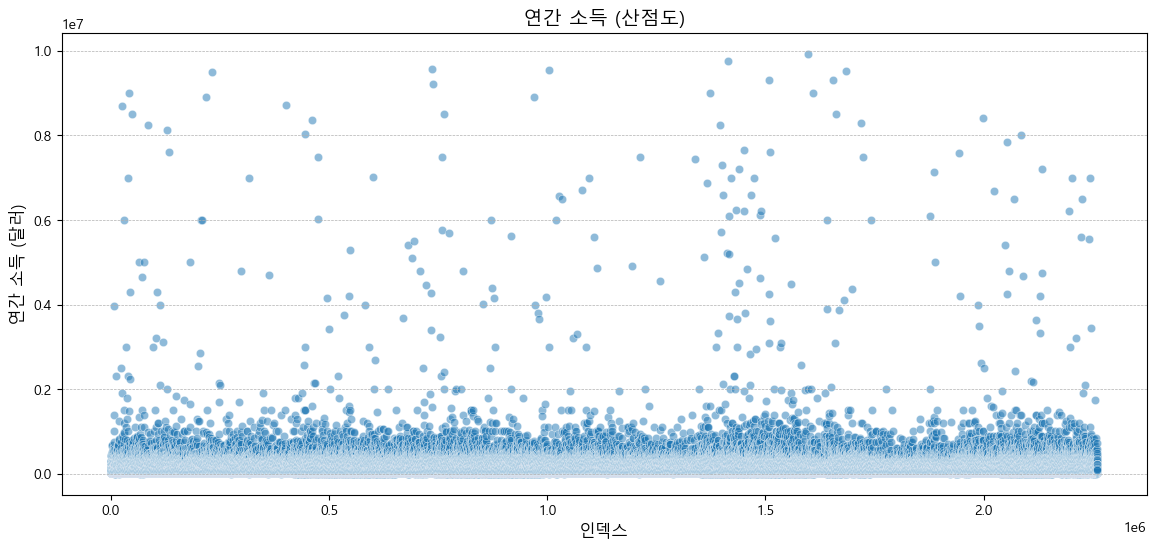

In [35]:
plt.figure(figsize=(14,6))

sns.scatterplot(x=df.index, y=df['annual_inc'], alpha=0.5)

plt.title('연간 소득 (산점도)' ,fontsize=14)
plt.ylabel('연간 소득 (달러)', fontsize=12)
plt.xlabel('인덱스', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.show()

##### 3. revol_util (신용한도 사용률)

- 일반적으로 100% 넘는 데이터들만 삭제하지만 7333건이 있고 200%이상인 데이터가 2건 있기때문에 200%까지 올리고 100% 이상값은 특별 범주로 묶어 리스크 관리 범주로 넣음

- 200% 넘는 데이터는 총 2개로 제거

In [36]:
# 전체 데이터 개수
total_count = len(df)

# 100% 이상
count_over_100 = len(df[df['revol_util'] > 100])
pct_over_100 = (count_over_100 / total_count) * 100 # 비율 확인용

# 200% 이상
count_over_200 = len(df[df['revol_util'] > 200])
pct_over_200 = (count_over_200 / total_count) * 100

print(f"revol_util 전체 데이터 (총 {total_count:,}건)")
print(f"100% 초과 : {count_over_100:,}건 ({pct_over_100:.2f}%)") 
print(f"200% 초과 : {count_over_200:,}건 ({pct_over_200:.4f}%)")

revol_util 전체 데이터 (총 2,257,154건)
100% 초과 : 7,335건 (0.32%)
200% 초과 : 2건 (0.0001%)


- 산점도로 확인

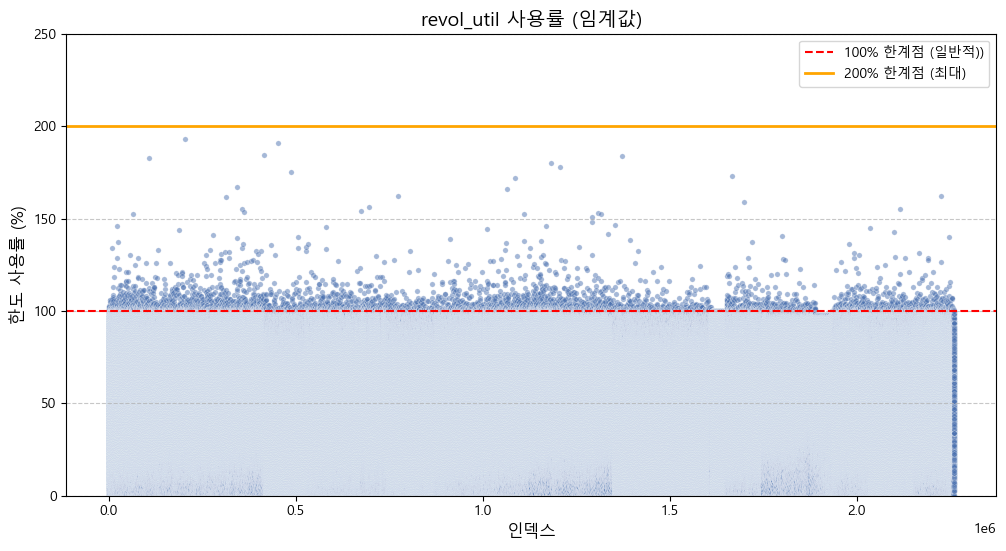

In [37]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.index, y=df['revol_util'], alpha=0.5, s=15, color='#4c72b0')

# 빨간선 (100%)
plt.axhline(100, color='red', linestyle='--', linewidth=1.5, label='100% 한계점 (일반적))')
# 주황선 (200%)
plt.axhline(200, color='orange', linestyle='-', linewidth=2, label='200% 한계점 (최대)')

plt.title('revol_util 사용률 (임계값)', fontsize=14)
plt.ylabel('한도 사용률 (%)', fontsize=12)
plt.xlabel('인덱스', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# y축 위에도 있는지 보여줌
plt.ylim(0, 250)
plt.show()

- 이상치 처리

박스플롯 상으로는 125%부터 이상치로 분류되나, 산점도를 통해 확인한 결과 100%~200% 구간에도 다수의 데이터가 존재함을 확인

따라서 단순 삭제보다는 200%를 초과하는 명백한 이상치만 제거하여 리스크 분석의 정밀도를 높임

In [38]:
df = df[df['revol_util'] <= 200]

# 100% 이상
count_over_100 = len(df[df['revol_util'] > 100])
pct_over_100 = (count_over_100 / total_count) * 100 # 여기는 비율 확인용

# 200% 이상
count_over_200 = len(df[df['revol_util'] > 200])
pct_over_200 = (count_over_200 / total_count) * 100

print(f"revol_util 전체 데이터 (총 {total_count:,}건)")
print(f"100% 초과 : {count_over_100:,}건 ({pct_over_100:.2f}%)") 
print(f"200% 초과 : {count_over_200:,}건 ({pct_over_200:.4f}%)")

revol_util 전체 데이터 (총 2,257,154건)
100% 초과 : 7,333건 (0.32%)
200% 초과 : 0건 (0.0000%)


##### 4. peb_rec (공공 기록)

- 오른쪽 꼬리가 엄청길고 중간에 이상한 값(40,80)등 튀어나와있음
- 클리핑(상한선) 기준을 99.5%인 3회로 잡고 그보다 큰값은 3회로 변환

- 수치로 확인

In [39]:
print(f"최대값: {df['pub_rec'].max()}")
print("상위 10개 값 빈도수:")
print(df['pub_rec'].value_counts().sort_index(ascending=False).head(10))

최대값: 86.0
상위 10개 값 빈도수:
pub_rec
86.0    1
63.0    1
61.0    2
54.0    1
52.0    1
49.0    2
47.0    1
46.0    1
45.0    1
44.0    1
Name: count, dtype: int64


- 바플롯(bar_plot)으로 확인

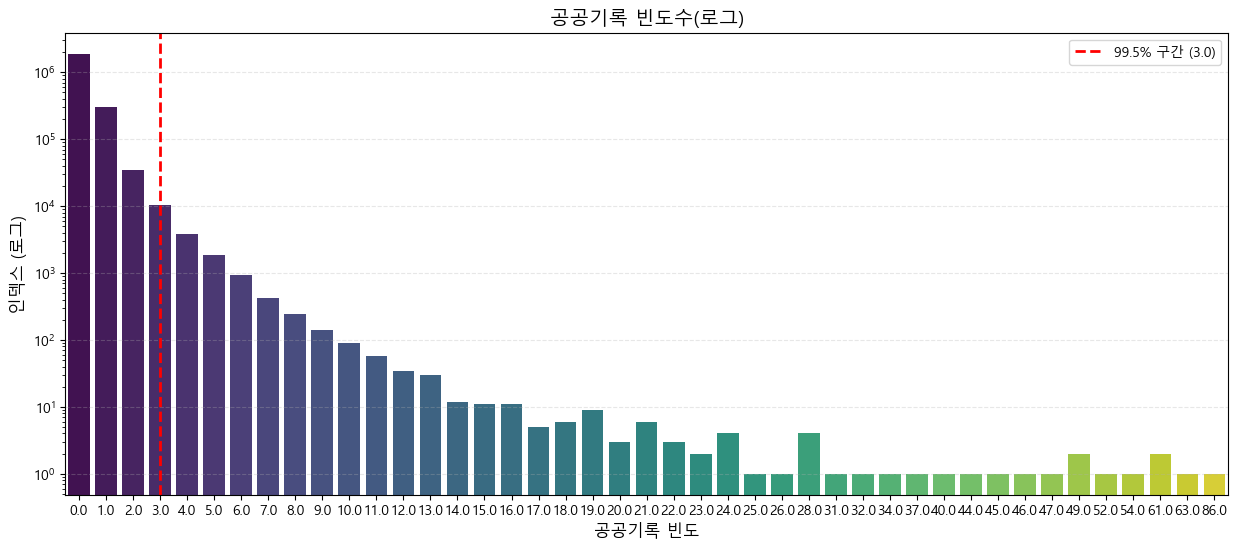

In [40]:
pub_rec_counts = df['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(15, 6))

# 바플롯(bar)
pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')

# y스케일을 로그로해야 잘 보인다고하네요
plt.yscale('log')

# 기준선은 99.5
limit_995 = df['pub_rec'].quantile(0.995)
# 약간의 보정
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')


plt.title('공공기록 빈도수(로그)', fontsize=14)
plt.xlabel('공공기록 빈도', fontsize=12)
plt.ylabel('인덱스 (로그)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

- 상위 99.5%값으로 클리핑

In [41]:
# 1. Pub_rec: 상위 99.5% 값으로 클리핑
limit_995 = df['pub_rec'].quantile(0.995) # 분위수(0.995)
df['pub_rec'] = df['pub_rec'].clip(upper=limit_995) 
print(f"pub_rec 상한선 적용값: {limit_995}회") # 횟수 확인

pub_rec 상한선 적용값: 3.0회


- 이상치 제거 확인

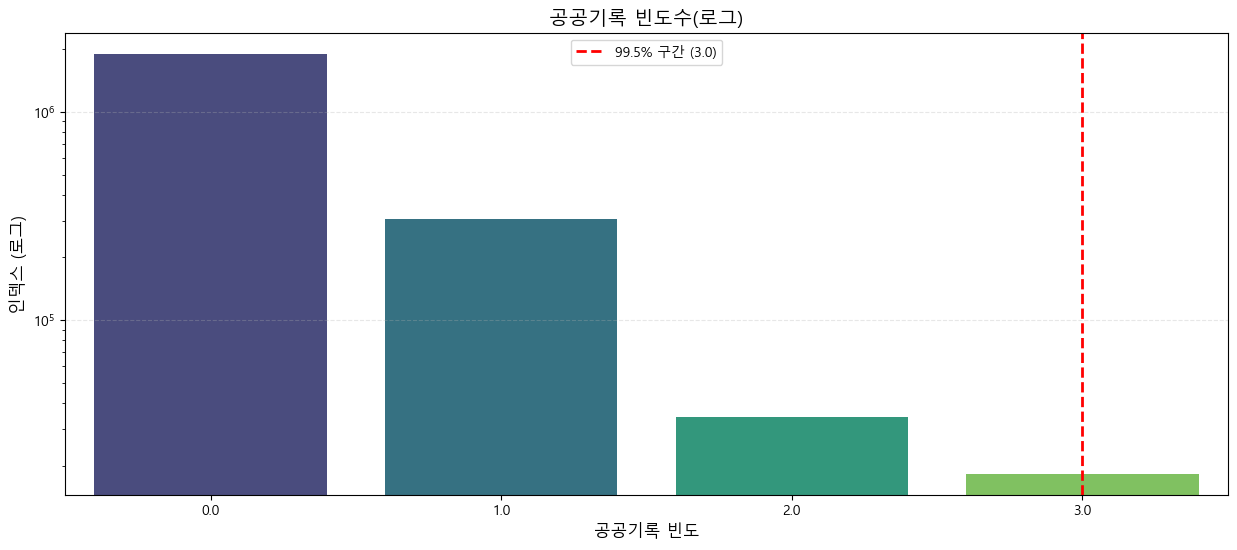

In [42]:
pub_rec_counts = df['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(15, 6))

# 바플롯(bar)
pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')

# y스케일을 로그로해야 잘 보인다고하네요
plt.yscale('log')

# 기준선은 99.5
limit_995 = df['pub_rec'].quantile(0.995)
# 약간의 보정
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')


plt.title('공공기록 빈도수(로그)', fontsize=14)
plt.xlabel('공공기록 빈도', fontsize=12)
plt.ylabel('인덱스 (로그)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

In [43]:
# 전처리완료 폴더에 저장 (폴더 위치확인필요)
df.to_csv('../전처리 완료/lendingclub 전처리 완료.csv', index=False)

print("저장완료")

저장완료
